In [16]:
%load_ext autoreload
%autoreload 2
import os; import sys;sys.path.append("..")
import pandas as pd
import numpy as np
import tqdm
import socceraction.spadl as spadl
import matplotsoccer
import urllib
import zipfile
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# PART 1:  DOWNLOAD STATSBOMB DATA AND CONVERT TO SPADL

In [75]:
datafolder = "../data/"

statsbombzip = os.path.join(datafolder,"statsbomb-open-data.zip")
statsbombraw = os.path.join(datafolder,"statsbomb-raw")
statsbombjson =  os.path.join(statsbombraw,"open-data-master","data")

statsbombh5 = os.path.join(datafolder,"statsbomb.h5")
spadlh5 = os.path.join(datafolder,"spadl-statsbomb.h5")

### Download and extract the Statsbomb event data

In [ ]:
url = "https://github.com/statsbomb/open-data/archive/master.zip"
urllib.request.urlretrieve(url, statsbombzip)

In [ ]:
with zipfile.ZipFile(statsbombzip, 'r') as zipObj:
    zipObj.extractall(statsbombraw)

### Convert raw Statsbomb json files to Statsbomb HDF5 file

In [ ]:
%%time
spadl.statsbombjson_to_statsbombh5(statsbombjson,statsbombh5)

In [ ]:
# uncomment to inspect the data
matches = pd.read_hdf(statsbombh5,"matches")
players = pd.read_hdf(statsbombh5,"players")
teams = pd.read_hdf(statsbombh5,"teams")
competitions = pd.read_hdf(statsbombh5,"competitions")
match_id = matches.match_id[0]
events = pd.read_hdf(statsbombh5,f"events/match_{match_id}")

#matches[:5]
#players[:5]
#teams[:5]
#competitions[:5]
#events[:5]

### Convert Statsbomb data (in a HDF5 file) to the SPADL format (in a HDF5 file)

In [85]:
spadl.statsbombh5_to_spadlh5(statsbombh5,spadlh5)

converting statsbomb events to spadl actions: 100%|██████████| 257/257 [02:10<00:00,  1.71it/s]


In [ ]:
# uncomment to inspect the data

games = pd.read_hdf(spadlh5,"games")
players = pd.read_hdf(spadlh5,"players")
teams = pd.read_hdf(spadlh5,"teams")
competitions = pd.read_hdf(spadlh5,"competitions")
actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

game_id = games.game_id[0]
actions = pd.read_hdf(spadlh5,f"actions/game_{game_id}")

#matches[:5]
#players[:5]
#teams[:5]
#competitions[:5]
actions[:5]

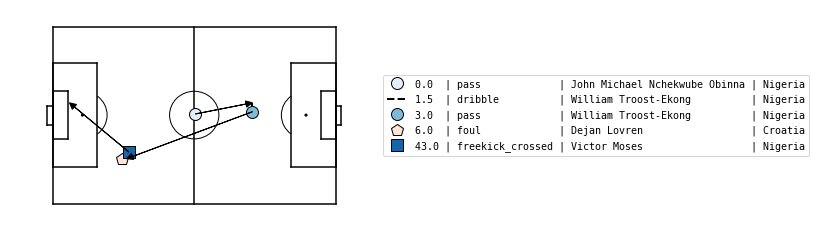

In [86]:
# Plot statsbomb data
games = pd.read_hdf(spadlh5,"games")
players = pd.read_hdf(spadlh5,"players")
teams = pd.read_hdf(spadlh5,"teams")
competitions = pd.read_hdf(spadlh5,"competitions")
actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

game_id = games.game_id[10]
actions = pd.read_hdf(spadlh5,f"actions/game_{game_id}")
actions = (
    actions.merge(actiontypes)
    .merge(results)
    .merge(bodyparts)
    .merge(players,"left",on="player_id")
    .merge(teams,"left",on="team_id")
    .sort_values(["period_id", "time_seconds", "timestamp"])
    .reset_index(drop=True)
)

a = actions[0:5]
labels = a[["time_seconds","type_name","player_name","team_name"]]
matplotsoccer.actions(location=a[["start_x","start_y","end_x","end_y"]],
                    action_type = a.type_name,
                    team=a.team_name,
                    result = a.result_name,
                    label=labels,
                    zoom=False)

# PART 2: COMPUTE SPADL VALUES OF ALL ACTIONS IN A COMPETITION

### Select a competition and choose file names for the features, labels and predictions

In [87]:
games = pd.read_hdf(spadlh5,"games")
games = games[games.competition_name == "FIFA World Cup"]
print("nb of games:", len(games))


featuresh5 = os.path.join(datafolder,"features-statsbomb.h5")
labelsh5 = os.path.join(datafolder,"labels-statsbomb.h5")
predictionsh5 =  os.path.join(datafolder,"predictions-statsbomb.h5")

nb of games: 64


## Generate and store all SPADL features

In [88]:
import socceraction.classification.features as fs

actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

xfns = [fs.actiontype,
       fs.actiontype_onehot,
       fs.bodypart,
       fs.bodypart_onehot,
       fs.result,
       fs.result_onehot,
       fs.goalscore,
       fs.startlocation,
       fs.endlocation,
       fs.movement,
       fs.space_delta,
       fs.startpolar,
       fs.endpolar,
       fs.team,
       fs.time,
       fs.time_delta
      ]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Generating and storing features in {featuresh5}"):
    actions = pd.read_hdf(spadlh5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    gamestates = fs.gamestates(actions,3)
    gamestates = fs.play_left_to_right(gamestates,game.home_team_id)
    
    X = pd.concat([fn(gamestates) for fn in xfns],axis=1)
    X.to_hdf(featuresh5,f"game_{game.game_id}")

Generating and storing features in ../data/features-statsbomb.h5: 100%|██████████| 64/64 [00:22<00:00,  2.80it/s]


## Generate and store all SPADL labels

In [89]:
import socceraction.classification.labels as lab

actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

yfns = [lab.scores,lab.concedes,lab.goal_from_shot]

for game in tqdm.tqdm(list(games.itertuples()),desc=f"Computing and storing labels in {labelsh5}"):
    actions = pd.read_hdf(spadlh5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    
    Y = pd.concat([fn(actions) for fn in yfns],axis=1)
    Y.to_hdf(labelsh5,f"game_{game.game_id}")

Computing and storing labels in ../data/labels-statsbomb.h5: 100%|██████████| 64/64 [00:11<00:00,  5.53it/s]


# Solve two classication problems
1. select feature set X 
2. select labels Y
3. train classifiers F(X) = Y

In [90]:
# 1. Select feature set X
xfns = [#fs.actiontype,
       #fs.actiontype_onehot,
       #fs.bodypart,
       #fs.bodypart_onehot,
       #fs.result,
       fs.result_onehot,
       fs.goalscore,
       #fs.startlocation,
       #fs.endlocation,
       #fs.movement,
       #fs.space_delta,
       #fs.startpolar,
       fs.endpolar,
       #fs.team,
       fs.time,
       #fs.time_delta,
       #fs.actiontype_result_onehot
      ]
nb_prev_actions = 1

# generate the columns of the selected features
Xcols = fs.feature_column_names(xfns,nb_prev_actions)
X = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting features"):
    Xi = pd.read_hdf(featuresh5,f"game_{game_id}")
    X.append(Xi[Xcols])
X = pd.concat(X)

# 2. Select label Y
Ycols = ["scores","concedes"]
Y = []
for game_id in tqdm.tqdm(games.game_id,desc="selecting label"):
    Yi = pd.read_hdf(labelsh5,f"game_{game_id}")
    Y.append(Yi[Ycols])
Y = pd.concat(Y)
print("X:", list(X.columns))
print("Y:", list(Y.columns))

selecting label: 100%|██████████| 64/64 [00:00<00:00, 126.34it/s]


X: ['result_fail_a0', 'result_success_a0', 'result_offside_a0', 'result_owngoal_a0', 'result_yellow_card_a0', 'result_red_card_a0', 'goalscore_team', 'goalscore_opponent', 'goalscore_diff', 'end_dist_to_goal_a0', 'end_tan_angle_to_goal_a0', 'period_id_a0', 'time_seconds_a0', 'time_seconds_overall_a0']
Y: ['scores', 'concedes']


In [91]:
%%time

# 3. train classifiers F(X) = Y

import xgboost

Y_pred = pd.DataFrame()
for col in list(Y.columns):
    model = xgboost.XGBClassifier()
    model.fit(X,Y[col])
    Y_pred[col] = [p[1] for p in model.predict_proba(X)]

CPU times: user 8.7 s, sys: 12 ms, total: 8.71 s
Wall time: 8.71 s


In [92]:
from sklearn.metrics import brier_score_loss, roc_auc_score
for col in list(Y.columns):
    print(f"Y: {col}")
    print(f"Brier score: %.4f" % brier_score_loss(Y[col],Y_pred[col]))
    print(f"ROC AUC: %.4f" % roc_auc_score(Y[col],Y_pred[col]))

Y: scores
Brier score: 0.0103
ROC AUC: 0.8586
Y: concedes
Brier score: 0.0039
ROC AUC: 0.8697


# Save action predictions per game

In [93]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id,"loading game ids"):
    Ai = pd.read_hdf(spadlh5,f"actions/game_{game_id}")
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A,Y_pred],axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions,desc="saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_pred.columns].to_hdf(predictionsh5,f"game_{int(k)}")

saving predictions per game: 100%|██████████| 64/64 [00:00<00:00, 78.05it/s]


## Compute and inspect VAEP values

In [105]:
import socceraction.vaep as vaep

players = pd.read_hdf(spadlh5,"players")
teams = pd.read_hdf(spadlh5,"teams")
actiontypes = pd.read_hdf(spadlh5, "actiontypes")
bodyparts = pd.read_hdf(spadlh5, "bodyparts")
results = pd.read_hdf(spadlh5, "results")

A = []
for game in tqdm.tqdm(list(games.itertuples())):
    actions = pd.read_hdf(spadlh5,f"actions/game_{game.game_id}")
    actions = (
        actions.merge(actiontypes)
        .merge(results)
        .merge(bodyparts)
        .merge(players,"left",on="player_id")
        .merge(teams,"left",on="team_id")
        .sort_values(["period_id", "time_seconds", "timestamp"])
        .reset_index(drop=True)
    )
    preds = pd.read_hdf(predictionsh5,f"game_{game.game_id}")
    values = vaep.value(actions,preds.scores,preds.concedes)
    A.append(pd.concat([actions,preds,values],axis=1))
A = pd.concat(A).sort_values(["game_id","period_id", "time_seconds", "timestamp"]).reset_index(drop=True)

100%|██████████| 64/64 [00:05<00:00,  9.84it/s]


### inspect Belgium's top 10 most valuable actions

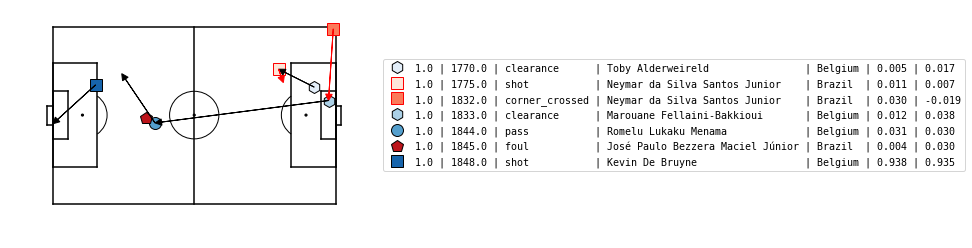

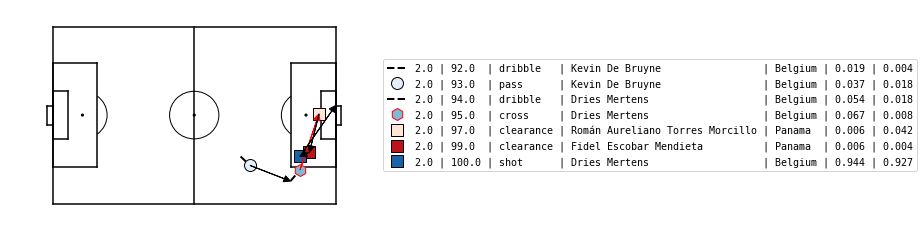

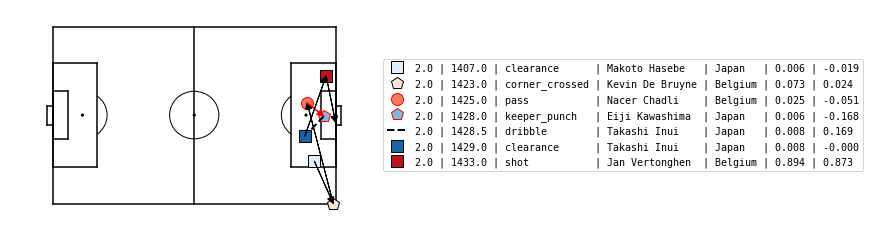

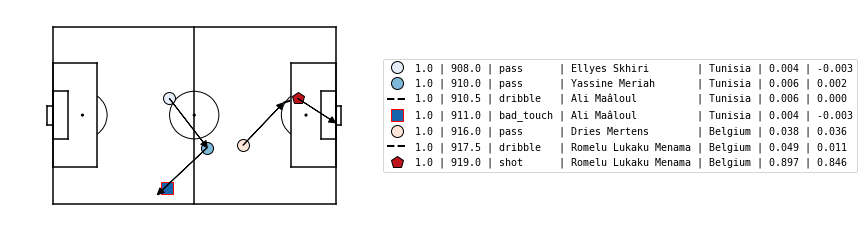

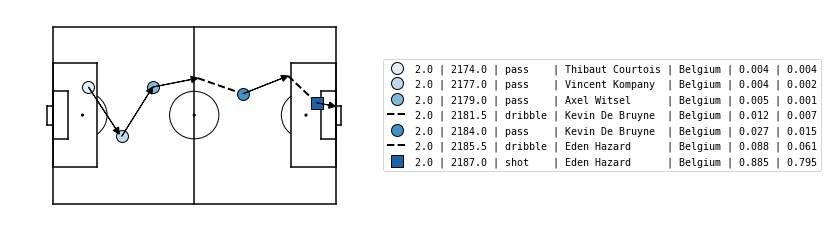

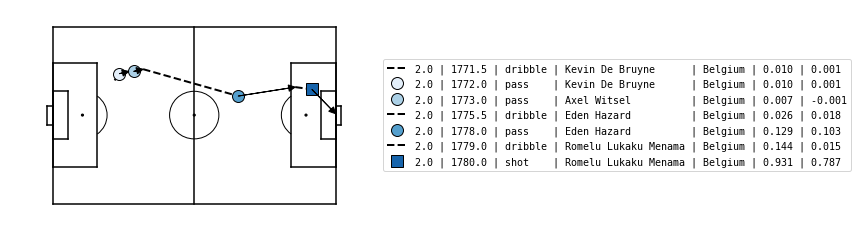

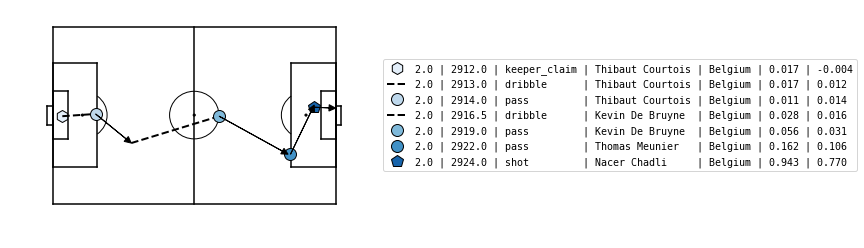

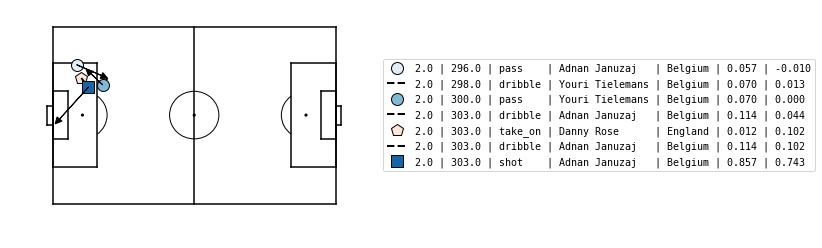

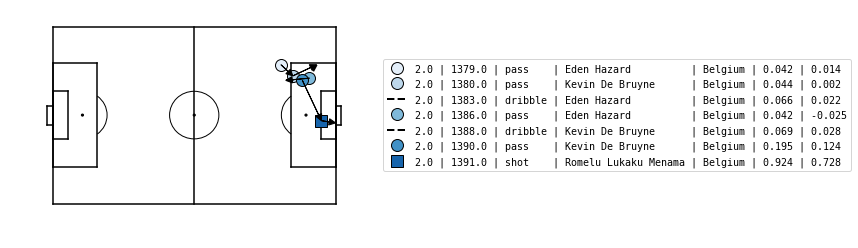

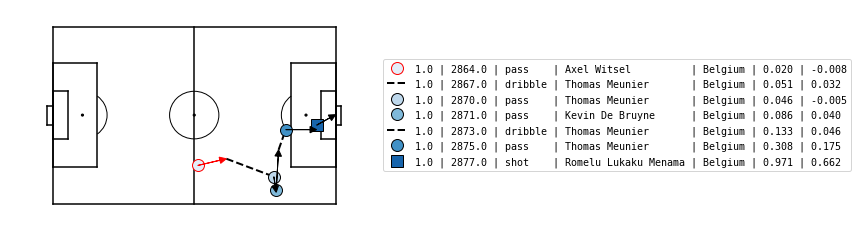

In [114]:

import matplotsoccer
sorted_A = A.sort_values("vaep_value", ascending=False)
belgium_A = sorted_A[sorted_A.team_name == "Belgium"]

i = 0
for j in range(i,i+10):
    i = belgium_A.index[j]    
    a = A[i - 6 : i+1].copy()
    a["scores"] = a.scores.apply(lambda x : "%.3f" % x )
    a["vaep_value"] = a.vaep_value.apply(lambda x : "%.3f" % x )
    labels = a[["period_id","time_seconds","type_name","player_name","team_name","scores","vaep_value"]]
    matplotsoccer.actions(a[["start_x","start_y","end_x","end_y"]],
                a.type_name,
                team=a.team_name,
                result = a.result_name == "success",
                label=labels,
                zoom=False)